In [1]:
import os
import sys
sys.path.append('..')  # 添加父文件夹到sys.path
sys.path.append('../src')  # 添加父文件夹到sys.path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import math

from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# from Model import DRSNet, RSBU_CW
import math
from fileTools import integrateData1D
# from src.ModelSV3 import *
import csv

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
import torch
import numpy as np

In [2]:
def calculate_rsd(data):
    mean_value = np.mean(data)
    std_deviation = np.std(data)
    rsd = (std_deviation / mean_value) * 100
    return rsd

In [3]:
def drawResult(Y, Y_pred, elements=['Mn', 'P', 'S', 'C'],graph_size=10):
    """
    绘制预测的结果，目前只能够支持固定的四种元素返回预测的结果值，后续可以考虑改进
    scores_dict = {'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555 , 'MSE': 555},
               'Mn': {'MAE': 555, 'MAPE': 555, 'R2': 555 , 'MSE': 555},
               'P': {'MAE': 555, 'MAPE': 555, 'R2': 555 , 'MSE': 555},
               'S': {'MAE': 555, 'MAPE': 555, 'R2': 555 , 'MSE': 555},
               'C': {'MAE': 555, 'MAPE': 555, 'R2': 555 , 'MSE': 555}}
    555 表示没有该数据的结果
    展示的图表中，只显示了 R2 和 RMSE
    后续根据需要进行更改
    :param Y: actual value 真实值
    :param Y_pred: predict value 预测值
    :param elements: elements list 元素列表['Fe', 'Mn', 'P', 'S', 'C']
    :param graph_size: 单个元素预测结果的尺寸
    :return: 返回存有各个元素预测评估结果的字典，例如 scores_dict['Fe']['MSE']
    """
    # 建立字典用来存放各个元素的结果评估分数
    scores_dict = {'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
                   'Mn': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555,  'RSD': 0, 'RMSE': 555},
                   'P': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555,  'RSD': 0, 'RMSE': 555},
                   'S': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555,  'RSD': 0, 'RMSE': 555},
                   'C': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555,  'RSD': 0, 'RMSE': 555}}
    model = LinearRegression()
    
    hash_table = {}
# 遍历y_test，将其分类并添加到哈希表中
    for i in range(len(Y)):
        key = tuple(Y[i])
        if key in hash_table:
            # 如果键已存在，追加到已有的值列表中
            hash_table[key].append(i)
        else:
            # 如果键不存在，创建新的键值对
            hash_table[key] = [i]
        
        
    if len(elements) == 1:
        i = 0
        model.fit(Y[:, i].reshape(-1, 1), Y_pred[:, i].reshape(-1, 1))
        fig, ax = plt.subplots(1, 1, figsize=(graph_size, graph_size))
        ax.set_title(elements[i])
        MAPE = mean_absolute_percentage_error(Y[:, i], Y_pred[:, i])
        MAE = mean_absolute_error(Y[:, i], Y_pred[:, i])
        R2 = r2_score(Y[:, i], Y_pred[:, i])
        MSE = mean_squared_error(Y[:, i], Y_pred[:, i])
        scores_dict[elements[i]]['MAE'] = MAE
        scores_dict[elements[i]]['MSE'] = MSE
        scores_dict[elements[i]]['RMSE'] = math.sqrt(MSE)
        scores_dict[elements[i]]['R2'] = R2
        scores_dict[elements[i]]['MAPE'] = MAPE
        scores_dict[elements[i]]['RSD'] = calculate_rsd(Y[:, i])
        # 添加文本信息，将坐标映射到对应子图
        # 保留7位小数
        plt.text(0.55, 0.1, 'R\u00b2={0:.7f}\nRMSE={1:.7f}'.format(R2, math.sqrt(MSE)),
                 # horizontalalignment='center',
                 # verticalalignment='center',
                 fontsize=12,
                 transform=ax.transAxes)
        # 预测结果绘制散点图，真实值绘制直线
        ax.scatter(Y[:, i], Y_pred[:, i], color='r', label="predict", marker = 'x')
        ax.plot(Y[:, i], model.predict(Y[:, i].reshape(-1, 1)), color='dodgerblue', label="predict regression")
        ax.plot(Y[:, i], Y[:, i], color='black', label="actual")
        ax.legend(loc='upper left')
        plt.show()
        return scores_dict
    elif len(elements) == 2:
        fig, ax = plt.subplots(1, 2, figsize=(2 * graph_size, graph_size))
    elif len(elements) == 5:
        fig, ax = plt.subplots(3, 2, figsize=(2 * graph_size, 3 * graph_size))  # 设置2*2 个子图和 尺寸
    else:
        fig, ax = plt.subplots(2, 2, figsize=(2.2 * graph_size, 2 * graph_size))  # 设置2*2 个子图和 尺寸
    axes = ax.flatten()  # 将ax 展开后可以根据索引指向对应子图（左到右，上到下）
    for i in range(len(elements)):
        axes[i].set_title(elements[i] + " concentration(wt%)")
        MAPE = mean_absolute_percentage_error(Y[:, i], Y_pred[:, i])
        MAE = mean_absolute_error(Y[:, i], Y_pred[:, i])
        R2 = r2_score(Y[:, i], Y_pred[:, i])
        MSE = mean_squared_error(Y[:, i], Y_pred[:, i])
        scores_dict[elements[i]]['MAE'] = MAE
        scores_dict[elements[i]]['MSE'] = MSE
        scores_dict[elements[i]]['R2'] = R2
        scores_dict[elements[i]]['MAPE'] = MAPE
        scores_dict[elements[i]]['RMSE'] = math.sqrt(MSE)
#         scores_dict[elements[i]]['RSD'] = calculate_rsd(Y[:, i])
        # 添加文本信息，将坐标映射到对应子图
#         plt.text(0.65, 0.1, 'R\u00b2={0:.7f}\nRSD={1:.7f}'.format(R2,scores_dict[elements[i]]['RSD'] ),
#                  # horizontalalignment='center',
#                  # verticalalignment='center',
#                  fontsize=18,
#                  transform=axes[i].transAxes)
        # 预测结果绘制散点图，真实值绘制直线
#         axes[i].scatter(Y[:, i], Y_pred[:, i], color='r', label="predict", marker = 'x', alpha=0.5)
        model.fit(Y[:, i].reshape(-1, 1), Y_pred[:, i].reshape(-1, 1))
#         axes[i].plot(Y[:, i], model.predict(Y[:, i].reshape(-1, 1)), color='dodgerblue', label="predict regression")
        axes[i].plot(Y[:, i], Y[:, i], color='black', label="Reference Line")
        axes[i].legend(loc='upper left')
        pos = []
        all_data = []
        tmp = 0
        for key, value in hash_table.items():
            pos.append(key[i])
            all_data.append(Y_pred[value, i])
            y_err = np.std(Y_pred[value, i]) / np.sqrt(len(Y_pred[value, i]))
            axes[i].errorbar(key[i],Y_pred[value, i].mean(), yerr=3 * y_err, fmt='ro-', ecolor='b', elinewidth=3, capsize=15)
            tmp = tmp + calculate_rsd(Y_pred[value, i])
        scores_dict[elements[i]]['RSD'] = scores_dict[elements[i]]['RSD'] + tmp / 9
        plt.text(0.65, 0.1, 'R\u00b2={0:.7f}\nRSD={1:.7f}'.format(R2,scores_dict[elements[i]]['RSD'] ),
                 # horizontalalignment='center',
                 # verticalalignment='center',
                 fontsize=20,
                 transform=axes[i].transAxes)
            
#         gap = max(pos) - min(pos)
#         axes[i].boxplot(all_data, patch_artist=True, positions=pos, widths = gap * 0.08,showbox = False)
#         axes[i].set_xticks([])  # 禁用横坐标显示
#         axes[i].set_xlim([min(pos) - (gap * 0.1), max(pos) + (gap * 0.1)])
        axes[i].grid(True)
    plt.rcParams.update({'font.size': 20})  # 将 14 修改为你想要的字体大小
    plt.show()
    return scores_dict

In [4]:
def getNNModelResult(model, x_list, num=4):
    model = model.cuda()
    model = model.double()
    x_list = torch.tensor(x_list)
    x_list = x_list.unsqueeze(1)
    x_list = x_list.cuda()
    x_list.double()
    result = np.zeros([0,num])
    for x in x_list:
        x=x.unsqueeze(0)
        y=model(x)
        y=y.detach()
        y=y.cpu()
        y=y.numpy()
        y = y.reshape(1,4)
#         print(result.shape)
#         print(y.shape)
        result=np.append(result, y, axis=0)
    return result

In [5]:
# %matplotlib

In [6]:
import os
import pandas as pd
import numpy as np
from fileTools import integrateData1D
from sklearn.model_selection import train_test_split

file_path="./data/anhuiD1_test/"

elemnts=['Mn','P','S','C']

data, label= integrateData1D(file_path, line_num=1, elements=elemnts, delete_outliers=False, fileNum = 1)
x_train,x_test,y_train,y_test=train_test_split(data,label,
                    test_size=0.2,random_state=27)#这里的test_size=0.2代表选择1/5的数据作为测试集

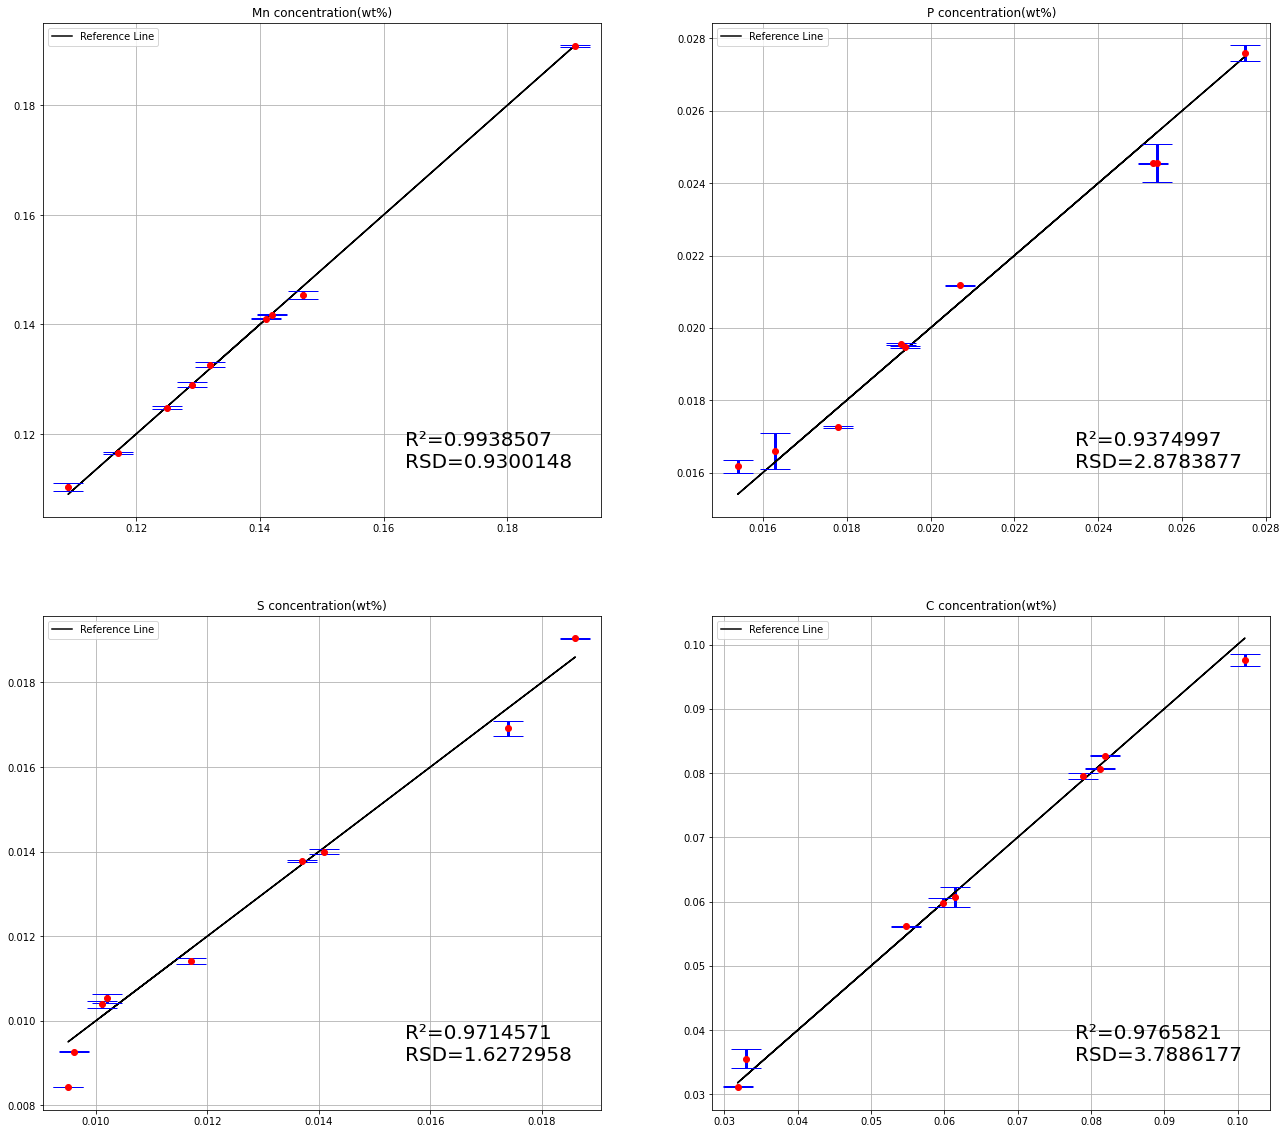

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.000694681477162586,
  'MAPE': 0.005417943494608585,
  'R2': 0.9938507448991769,
  'MSE': 2.95248551126939e-06,
  'RSD': 0.9300147579701711,
  'RMSE': 0.0017182798116923187},
 'P': {'MAE': 0.000569738943626273,
  'MAPE': 0.028367845183615084,
  'R2': 0.9374997477390661,
  'MSE': 1.0830360811819928e-06,
  'RSD': 2.8783877246065486,
  'RMSE': 0.0010406901946218158},
 'S': {'MAE': 0.00039157542714025775,
  'MAPE': 0.034201540679684304,
  'R2': 0.9714570743833664,
  'MSE': 2.895991573603031e-07,
  'RSD': 1.6272958375061368,
  'RMSE': 0.0005381441789709363},
 'C': {'MAE': 0.001598780111344257,
  'MAPE': 0.028105607628050013,
  'R2': 0.9765821189248083,
  'MSE': 1.0810746441500224e-05,
  'RSD': 3.7886177289979575,
  'RMSE': 0.0032879699575118116}}

In [7]:
model = torch.load("modelSave/e_DRSN_diff_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts) 

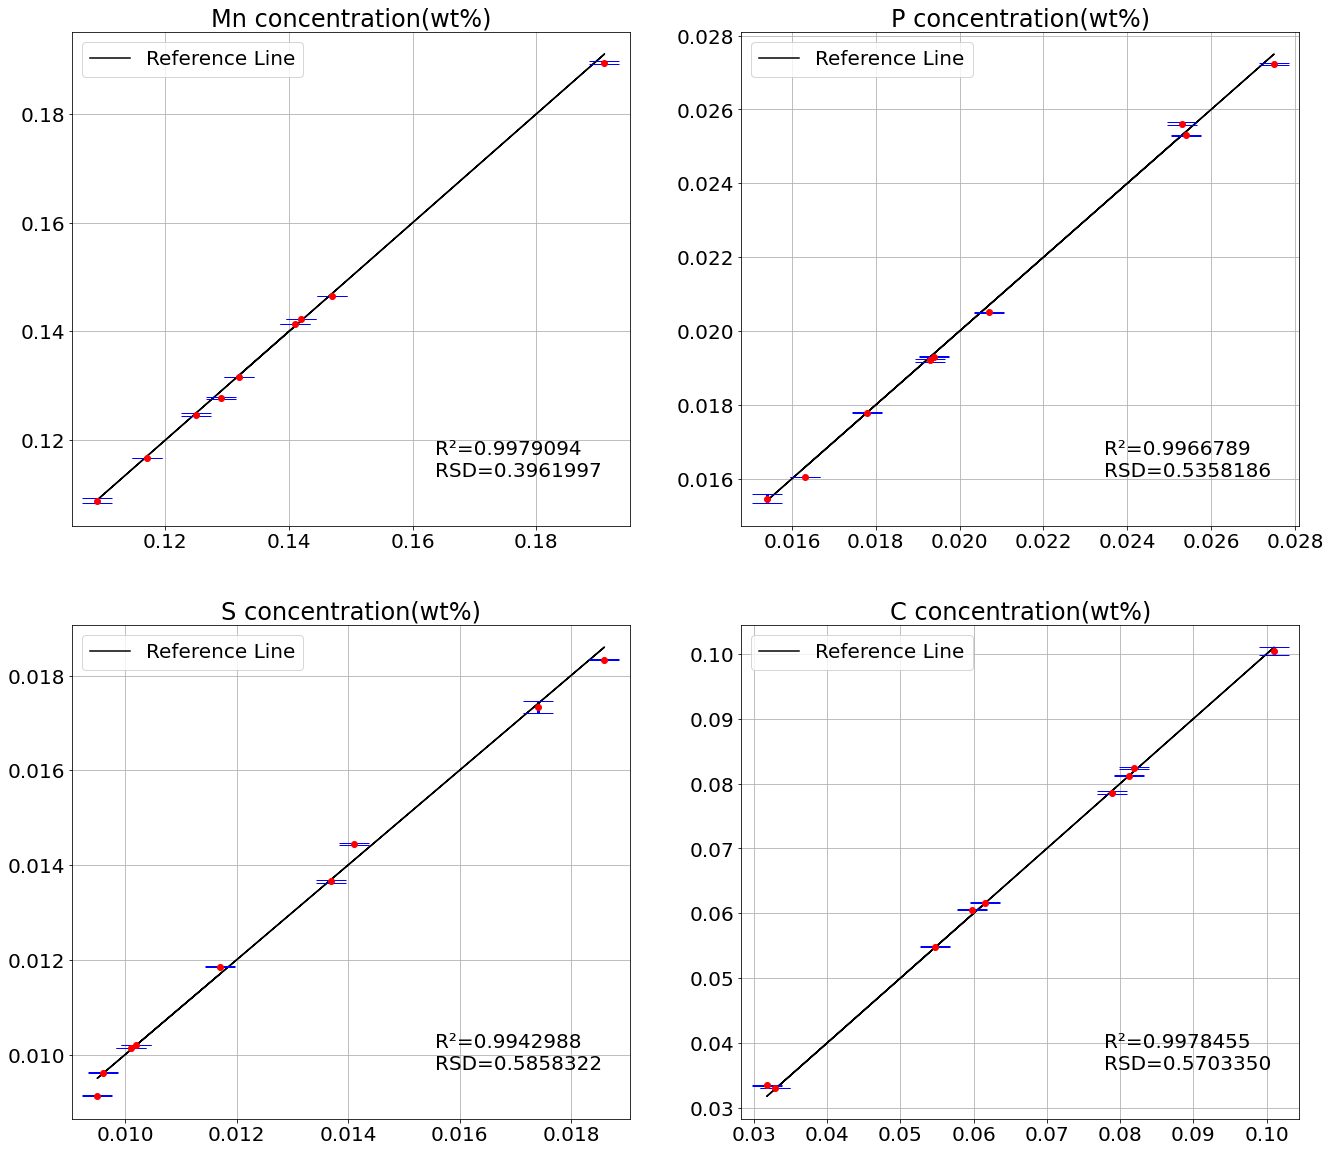

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.0006249574071567488,
  'MAPE': 0.004469832311062615,
  'R2': 0.9979094044383883,
  'MSE': 1.0037724902251233e-06,
  'RSD': 0.3961996900683189,
  'RMSE': 0.0010018844694999135},
 'P': {'MAE': 0.00016616393769925482,
  'MAPE': 0.007885260405306726,
  'R2': 0.9966788876401458,
  'MSE': 5.754991996455981e-08,
  'RSD': 0.5358185711017606,
  'RMSE': 0.00023989564390492757},
 'S': {'MAE': 0.00014813394069606035,
  'MAPE': 0.011705445223754352,
  'R2': 0.9942988342132933,
  'MSE': 5.7844554198027544e-08,
  'RSD': 0.5858321905851347,
  'RMSE': 0.0002405089482701788},
 'C': {'MAE': 0.0005063701590157278,
  'MAPE': 0.010398983936596877,
  'R2': 0.9978455152551761,
  'MSE': 9.946069934160793e-07,
  'RSD': 0.5703350382173518,
  'RMSE': 0.0009972998513065564}}

In [8]:
model = torch.load("modelSave/e_DRSN_diffCBAM_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts) 

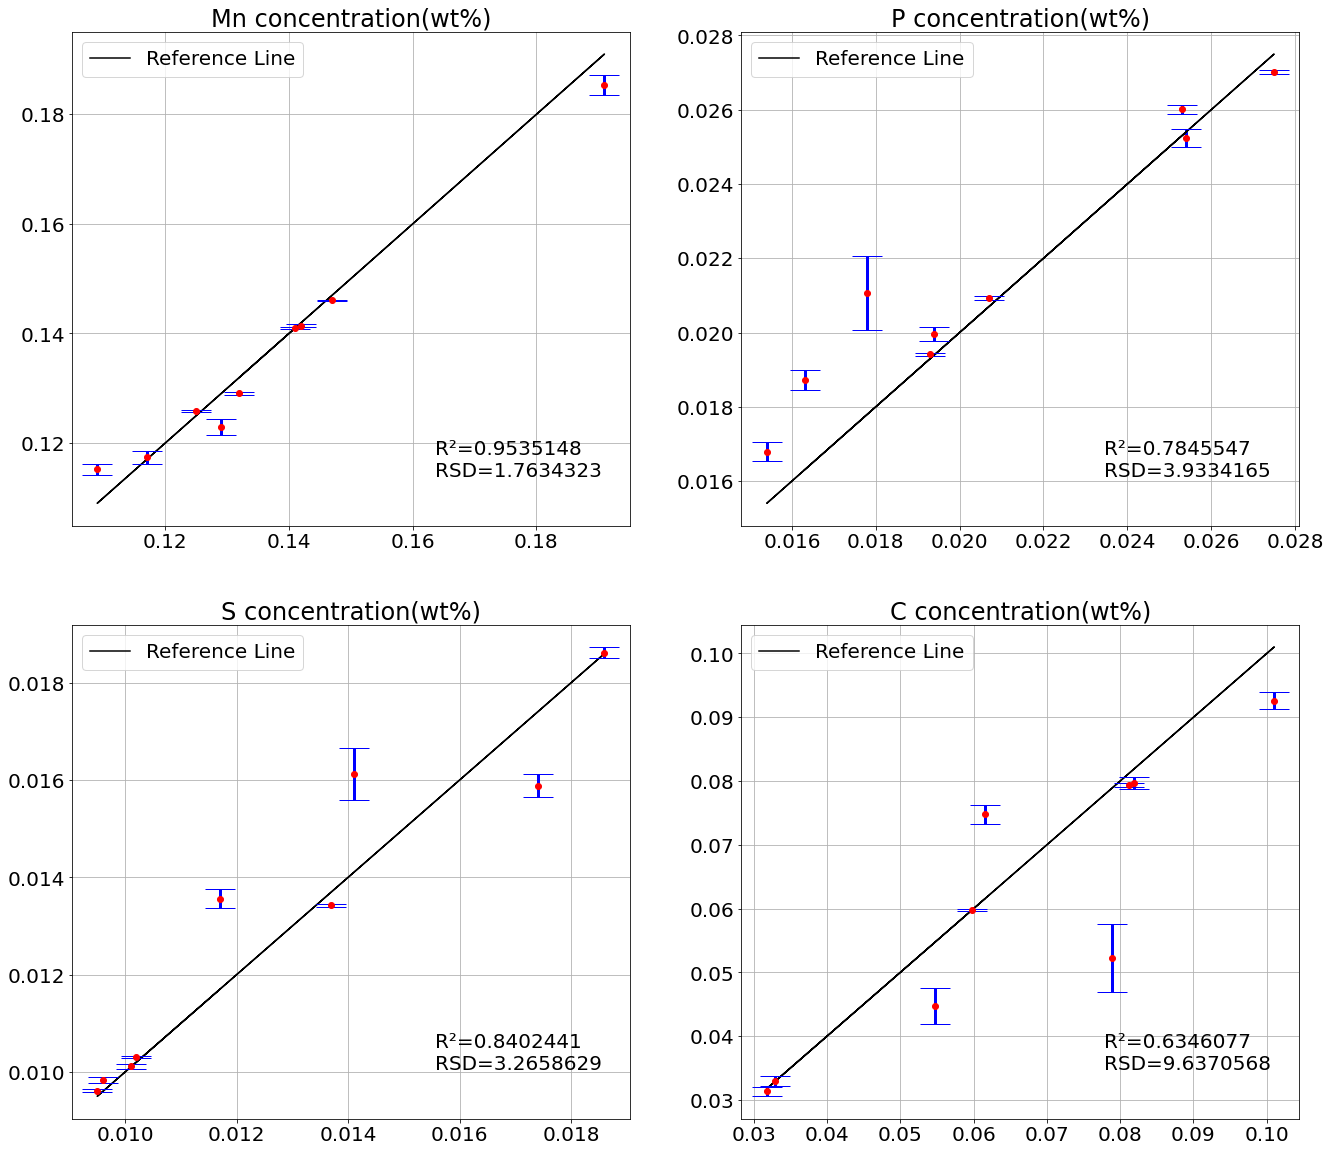

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.00274011749208253,
  'MAPE': 0.020518672052113582,
  'R2': 0.9535148241424841,
  'MSE': 2.231925752921771e-05,
  'RSD': 1.7634323055590193,
  'RMSE': 0.004724326145517232},
 'P': {'MAE': 0.0010685287087679454,
  'MAPE': 0.05941797971958399,
  'R2': 0.784554679147353,
  'MSE': 3.7333458276470834e-06,
  'RSD': 3.933416523256418,
  'RMSE': 0.001932186799366739},
 'S': {'MAE': 0.0007326956653982444,
  'MAPE': 0.05463947813680475,
  'R2': 0.8402440666004779,
  'MSE': 1.6208984431802194e-06,
  'RSD': 3.265862903883549,
  'RMSE': 0.0012731450990284725},
 'C': {'MAE': 0.007186294808682114,
  'MAPE': 0.10391851108797936,
  'R2': 0.6346076816809585,
  'MSE': 0.00016868151701409853,
  'RSD': 9.637056819157387,
  'RMSE': 0.012987744877926212}}

In [9]:
model = torch.load("modelSave/e_DRSN_1D_CBAM_v2_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts)

In [10]:
import os
import pandas as pd
import numpy as np
from fileTools import integrateData1D
from sklearn.model_selection import train_test_split

file_path="./data/test/"

elemnts=['Mn','P','S','C']

data, label= integrateData1D(file_path, line_num=1, elements=elemnts, delete_outliers=False, fileNum = 1)
x_train,x_test,y_train,y_test=train_test_split(data,label,
                    test_size=0.2,random_state=27)#这里的test_size=0.2代表选择1/5的数据作为测试集

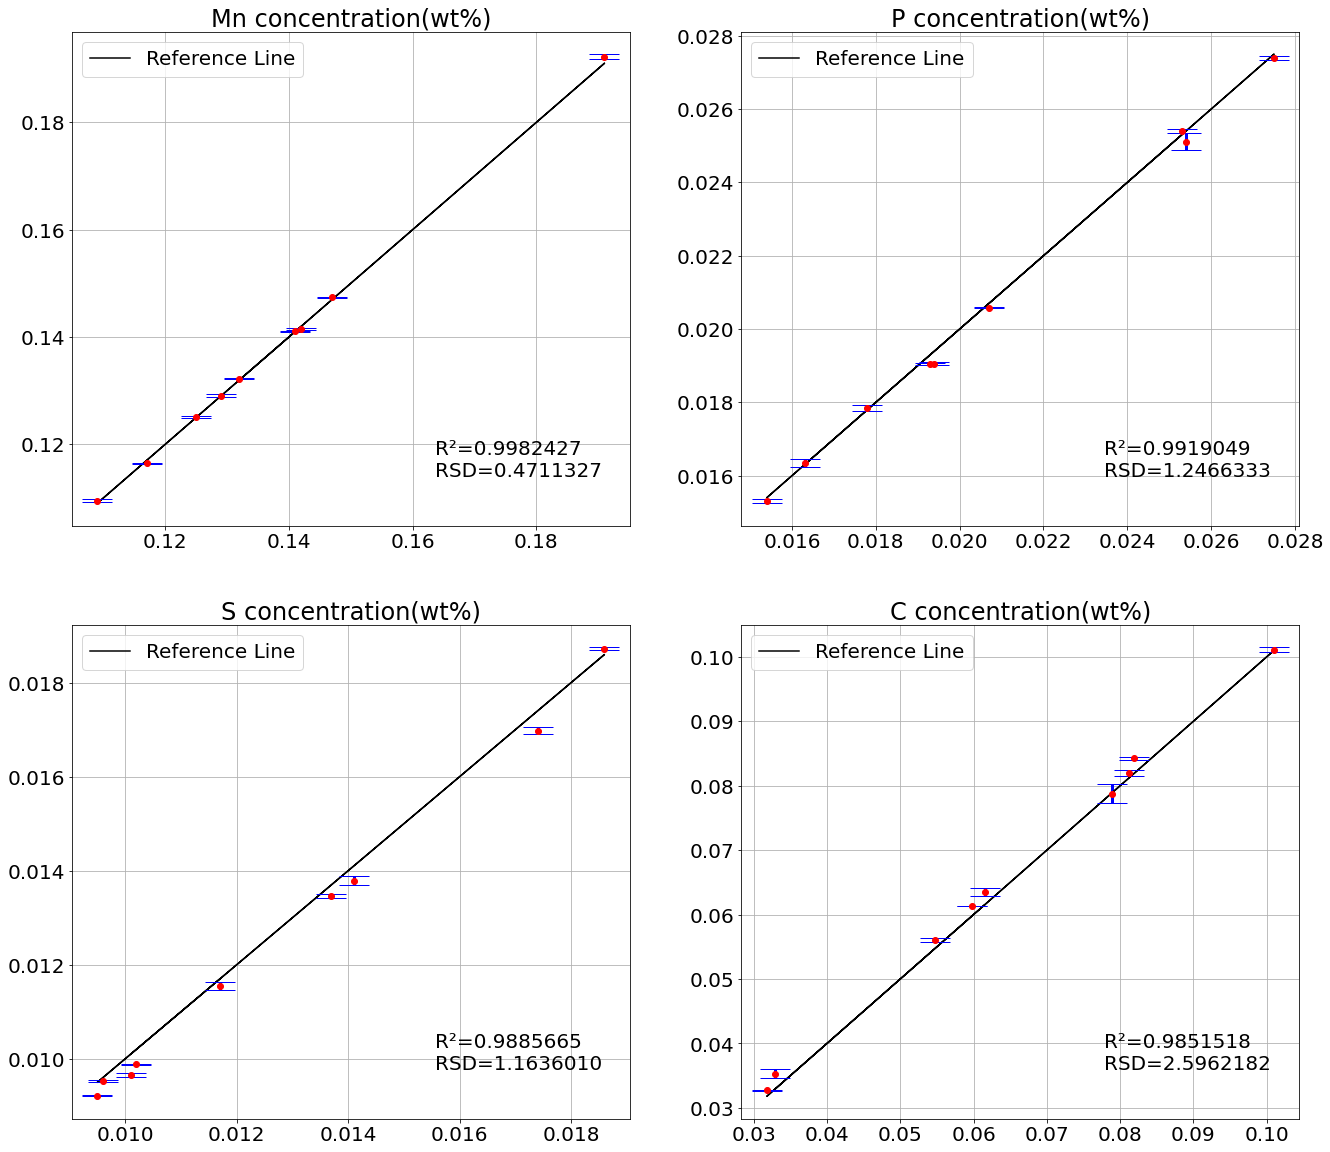

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.000556328879151047,
  'MAPE': 0.003888383076160198,
  'R2': 0.9982426793021212,
  'MSE': 8.437548636495314e-07,
  'RSD': 0.4711327141990533,
  'RMSE': 0.0009185613009753521},
 'P': {'MAE': 0.00019282205480042127,
  'MAPE': 0.009369657611235224,
  'R2': 0.9919048911758539,
  'MSE': 1.4027615282322687e-07,
  'RSD': 1.246633316659308,
  'RMSE': 0.00037453458161193455},
 'S': {'MAE': 0.0002865842555264529,
  'MAPE': 0.02379876559255198,
  'R2': 0.9885664565139282,
  'MSE': 1.160057873422471e-07,
  'RSD': 1.1636009719469456,
  'RMSE': 0.0003405962233235229},
 'C': {'MAE': 0.0016693281204152445,
  'MAPE': 0.029812530553101024,
  'R2': 0.9851518364143816,
  'MSE': 6.854579674848839e-06,
  'RSD': 2.5962181915352955,
  'RMSE': 0.0026181252213843477}}

In [11]:
model = torch.load("modelSave/e_DRSN_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts)

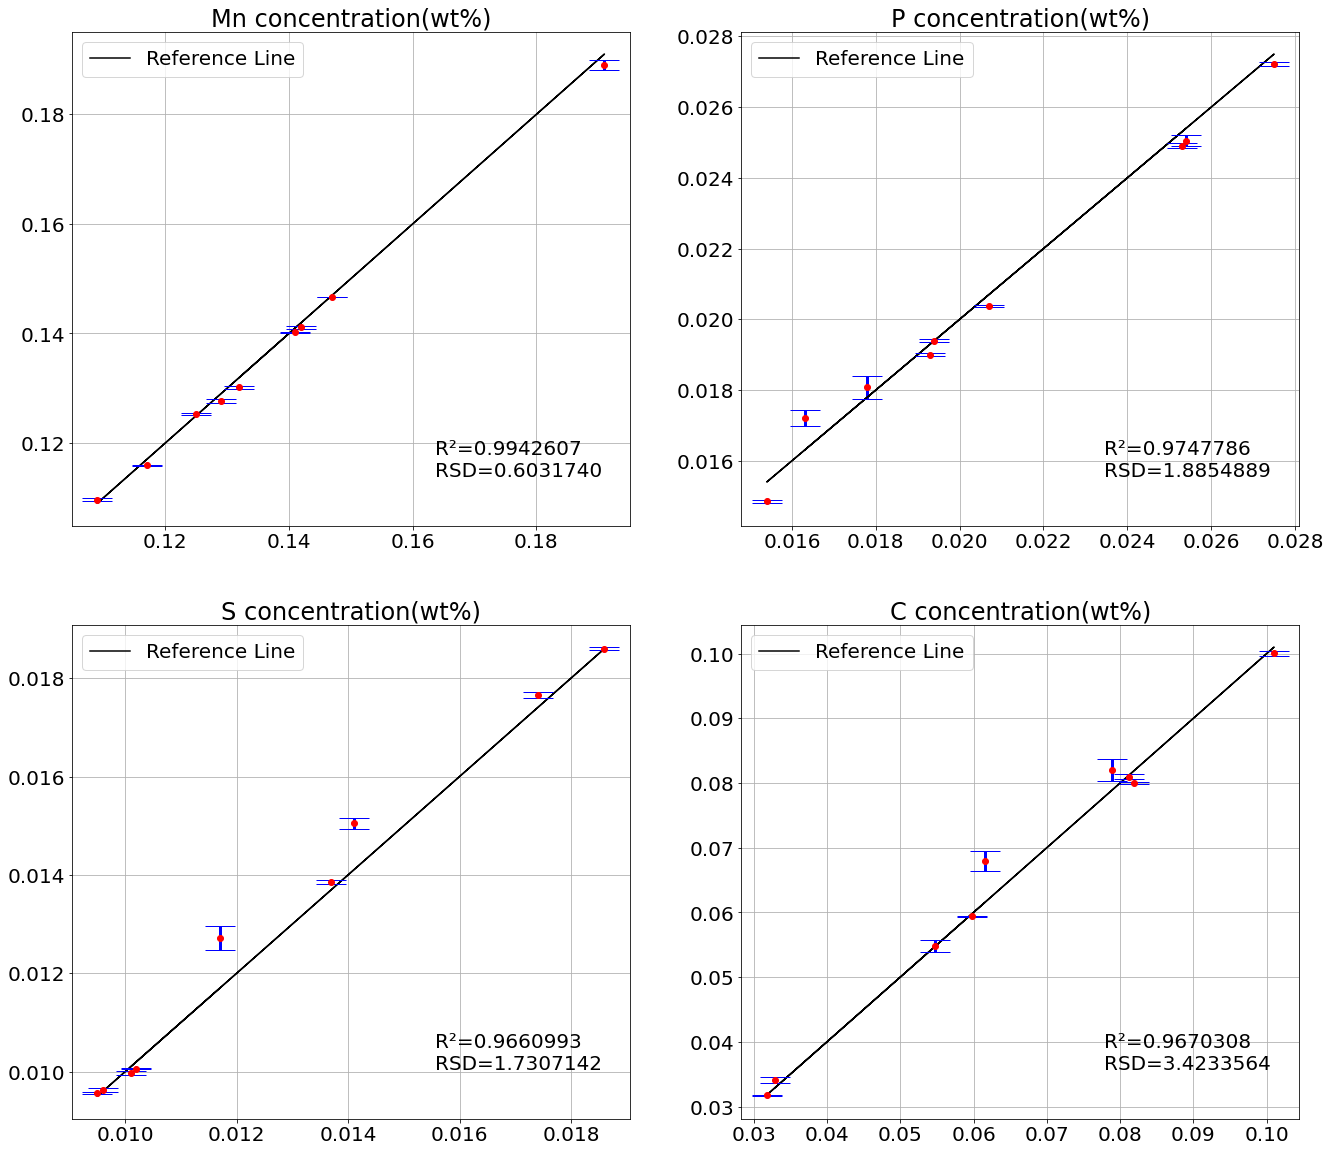

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.0011046540981699804,
  'MAPE': 0.007853998160964267,
  'R2': 0.9942607241692681,
  'MSE': 2.7556392534676963e-06,
  'RSD': 0.6031740121118851,
  'RMSE': 0.0016600118232915379},
 'P': {'MAE': 0.0003991840881774522,
  'MAPE': 0.02100422282812392,
  'R2': 0.9747786000418132,
  'MSE': 4.3704921475512407e-07,
  'RSD': 1.88548888148858,
  'RMSE': 0.0006610969783285384},
 'S': {'MAE': 0.00033722832577859005,
  'MAPE': 0.026664978848771406,
  'R2': 0.9660993022958555,
  'MSE': 3.4395960739656317e-07,
  'RSD': 1.7307142216416918,
  'RMSE': 0.0005864806965250972},
 'C': {'MAE': 0.0020268068311118967,
  'MAPE': 0.03219742796187874,
  'R2': 0.9670308044186796,
  'MSE': 1.5220062509731806e-05,
  'RSD': 3.423356407270986,
  'RMSE': 0.003901289852053011}}

In [12]:
model = torch.load("modelSave/e_ResNet_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts)

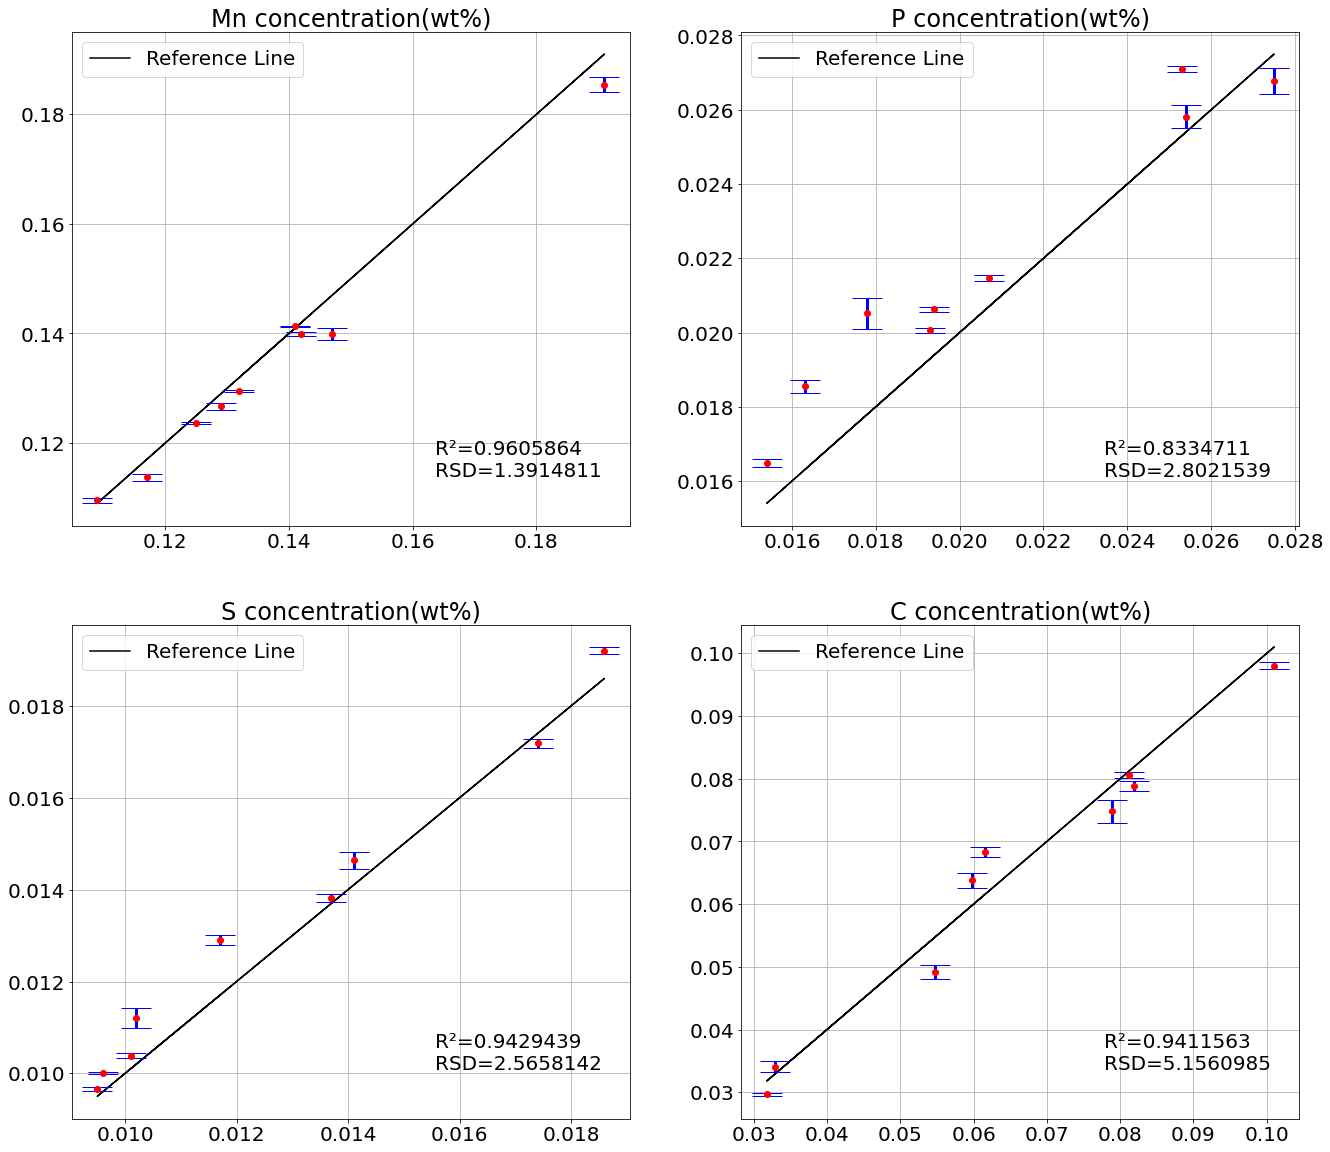

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.0030031323956283204,
  'MAPE': 0.02112735251263458,
  'R2': 0.9605864336161546,
  'MSE': 1.892391546419701e-05,
  'RSD': 1.391481052182067,
  'RMSE': 0.0043501626939916865},
 'P': {'MAE': 0.0014074930453430192,
  'MAPE': 0.07229106483260196,
  'R2': 0.8334711245979638,
  'MSE': 2.8856968427277618e-06,
  'RSD': 2.8021538727626925,
  'RMSE': 0.0016987338940304222},
 'S': {'MAE': 0.0005490432431524715,
  'MAPE': 0.046098992515167525,
  'R2': 0.9429439491176103,
  'MSE': 5.788959576105083e-07,
  'RSD': 2.5658141520404913,
  'RMSE': 0.0007608521259814605},
 'C': {'MAE': 0.003649094240771532,
  'MAPE': 0.0619458772926012,
  'R2': 0.9411562753092313,
  'MSE': 2.7164908100044132e-05,
  'RSD': 5.156098539739784,
  'RMSE': 0.0052119965560276545}}

In [13]:
model = torch.load("modelSave/e_CNN_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts)

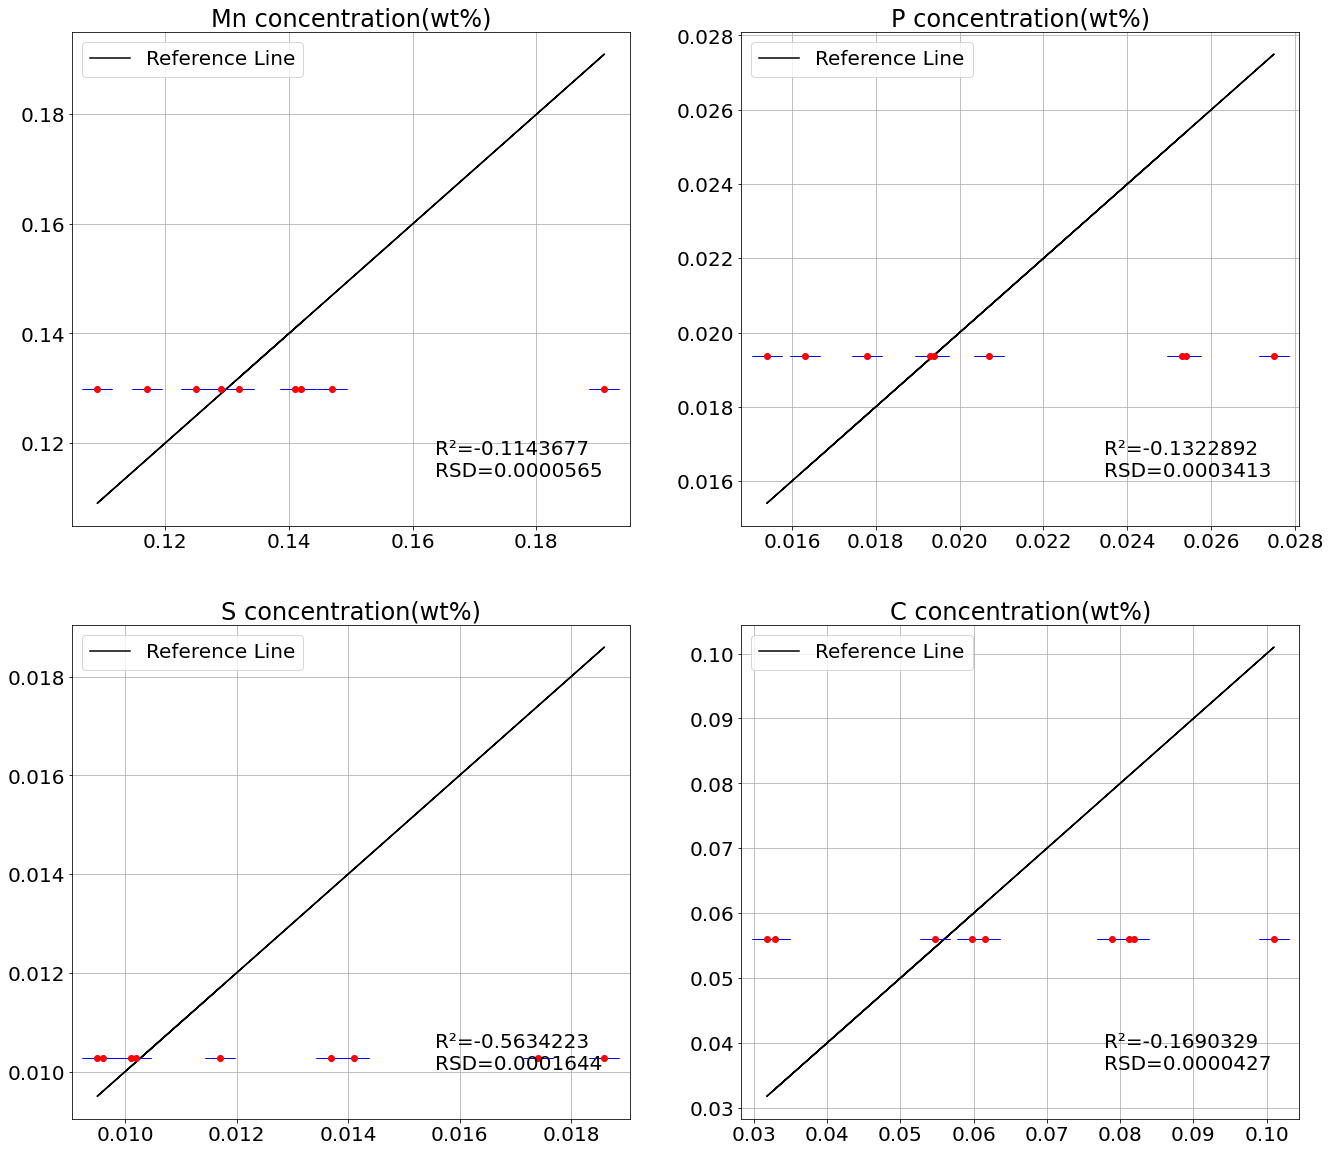

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.01577016665595273,
  'MAPE': 0.10629476629487637,
  'R2': -0.11436772011504126,
  'MSE': 0.0005350492854696475,
  'RSD': 5.6525368440482095e-05,
  'RMSE': 0.023131132386237548},
 'P': {'MAE': 0.0034647112774794857,
  'MAPE': 0.15658639221980214,
  'R2': -0.13228916338134078,
  'MSE': 1.962088109906519e-05,
  'RSD': 0.0003412722399908556,
  'RMSE': 0.004429546376217907},
 'S': {'MAE': 0.002764831339255653,
  'MAPE': 0.18021403149512658,
  'R2': -0.5634223148250741,
  'MSE': 1.5862627085002894e-05,
  'RSD': 0.00016436946475160885,
  'RMSE': 0.003982791368500602},
 'C': {'MAE': 0.01907951071572747,
  'MAPE': 0.32208064863131836,
  'R2': -0.16903285566610204,
  'MSE': 0.0005396781093818785,
  'RSD': 4.269773669253956e-05,
  'RMSE': 0.023230973061451353}}

In [14]:
model = torch.load("modelSave/e_DNN_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts)

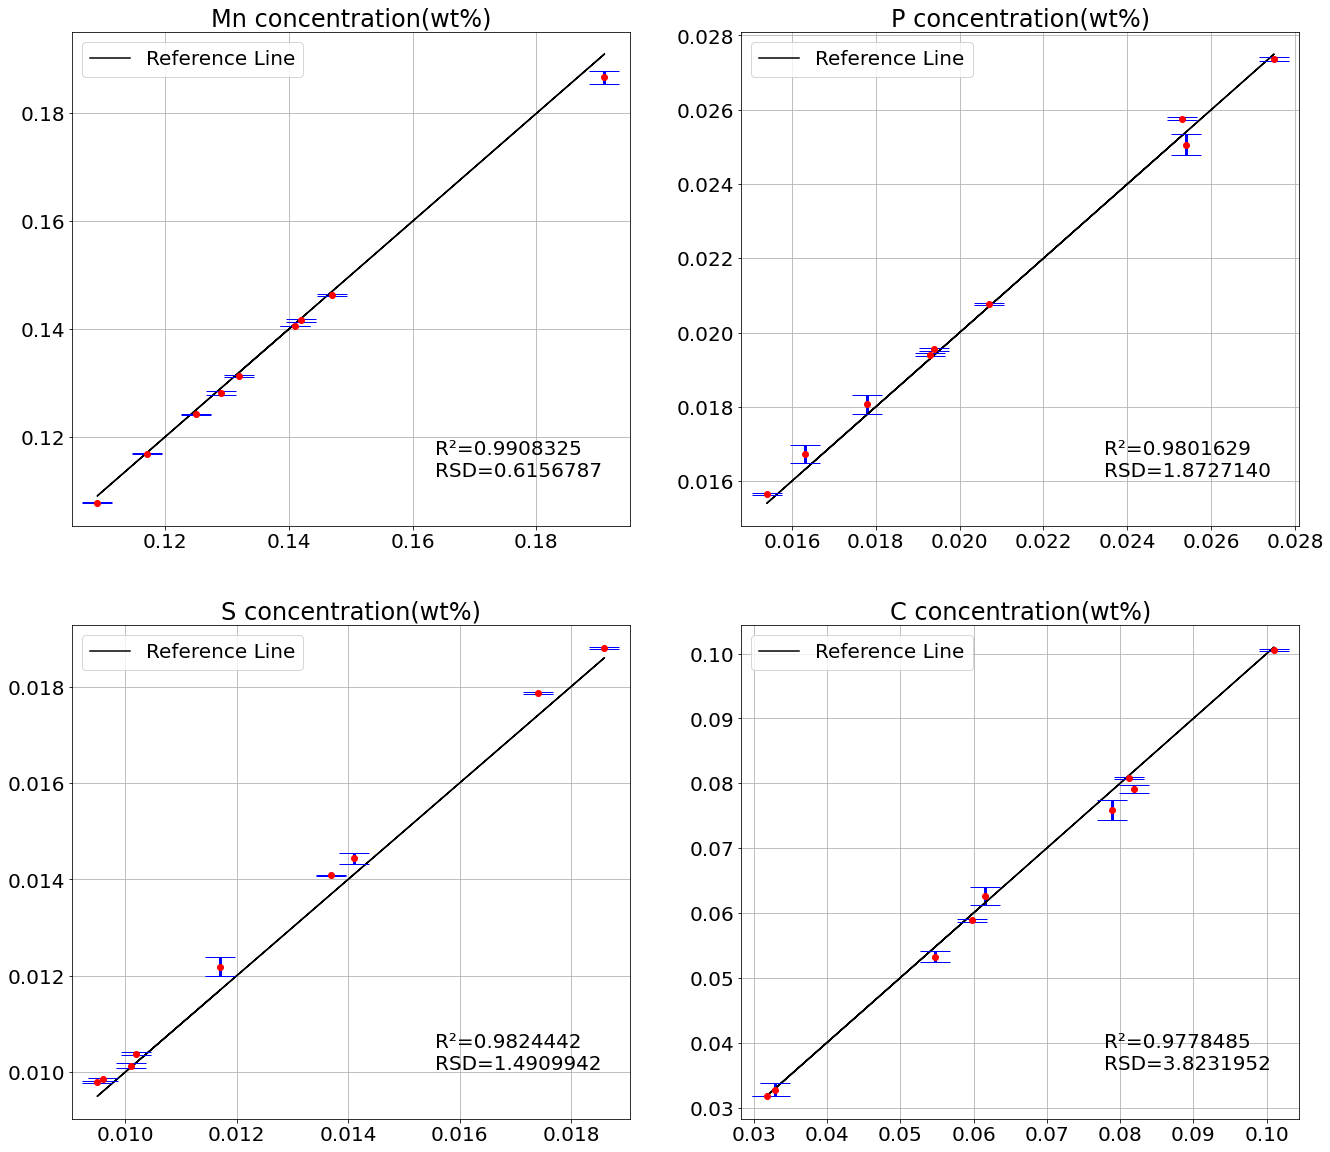

{'Fe': {'MAE': 555, 'MAPE': 555, 'R2': 555, 'MSE': 555, 'RSD': 0, 'RMSE': 555},
 'Mn': {'MAE': 0.0010639442975848461,
  'MAPE': 0.007148441246644996,
  'R2': 0.9908324566830977,
  'MSE': 4.401677662301821e-06,
  'RSD': 0.6156786920226325,
  'RMSE': 0.002098017555289236},
 'P': {'MAE': 0.00024939165412970056,
  'MAPE': 0.012542950120472848,
  'R2': 0.9801629300380701,
  'MSE': 3.43746812796954e-07,
  'RSD': 1.8727139558414132,
  'RMSE': 0.000586299251915738},
 'S': {'MAE': 0.00029431221315128083,
  'MAPE': 0.02353768901303565,
  'R2': 0.982444240796959,
  'MSE': 1.7812235298886855e-07,
  'RSD': 1.4909942472570648,
  'RMSE': 0.0004220454394835567},
 'C': {'MAE': 0.0014690225277850333,
  'MAPE': 0.023176981358535406,
  'R2': 0.9778484527543256,
  'MSE': 1.0226149829311005e-05,
  'RSD': 3.823195166490386,
  'RMSE': 0.003197835178571748}}

In [15]:
model = torch.load("modelSave/e_DRSN_CBAM_MAPE_Adam.pth")
y_pred = getNNModelResult(model, x_test, 4)
y_pred = y_pred
drawResult(y_test,y_pred,elemnts)